In [1]:
import os
os.chdir('../')

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
import sys
import datetime
import logging
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.auto import tqdm

import torch
import torchvision.transforms as transforms
from torchvision.datasets import MNIST

from lateral_connections.model_factory import load_model_by_key, get_config_by_key
from lateral_connections.loaders import *
from lateral_connections.loaders import get_loaders, load_mnistc

import wandb
import optuna


def small_transform():
    return transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5), std=(0.5))
    ])

[I 2022-07-03 16:55:18,075] Using an existing study with name 'tiny_cnn__optuna__full_trained' instead of creating a new one.
/tmp/ipykernel_342/1824899331.py:7: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)


{'lr': 0.0004040814591505001}


100

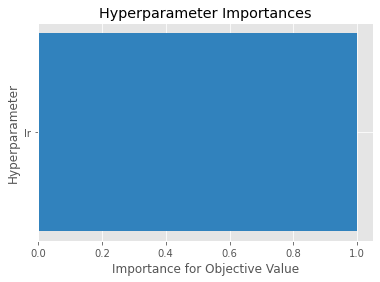

In [17]:
study_name = 'tiny_cnn__optuna__full_trained'
storage_name = "sqlite:///{}.db".format(study_name)
study = optuna.create_study(study_name=study_name, storage=storage_name, load_if_exists=True, direction='minimize')
best_params = study.best_trial.params
print(best_params)

optuna.visualization.matplotlib.plot_param_importances(study)
len(study.trials)

## MNIST

In [44]:
def get_dataset_loaders():
    train_dataset = MNIST('images/mnist/', train=True, transform=small_transform(), download=True)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=10, shuffle=True, num_workers=1)

    test_dataset = MNIST('images/mnist/', train=False, transform=small_transform(), download=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10, shuffle=False, num_workers=1)

    return train_loader, test_loader

In [45]:
l, _ = get_dataset_loaders()

data = {
    'i': [],
    'l': []
}

it = iter(l)

for _ in range(200):
    images, labels = next(it)
    
    data['i'].append(images)
    data['l'].append(labels)

In [46]:
images = torch.stack(data['i']).reshape((200*10, 1, 28, 28))
labels = torch.stack(data['l']).reshape((200*10,))

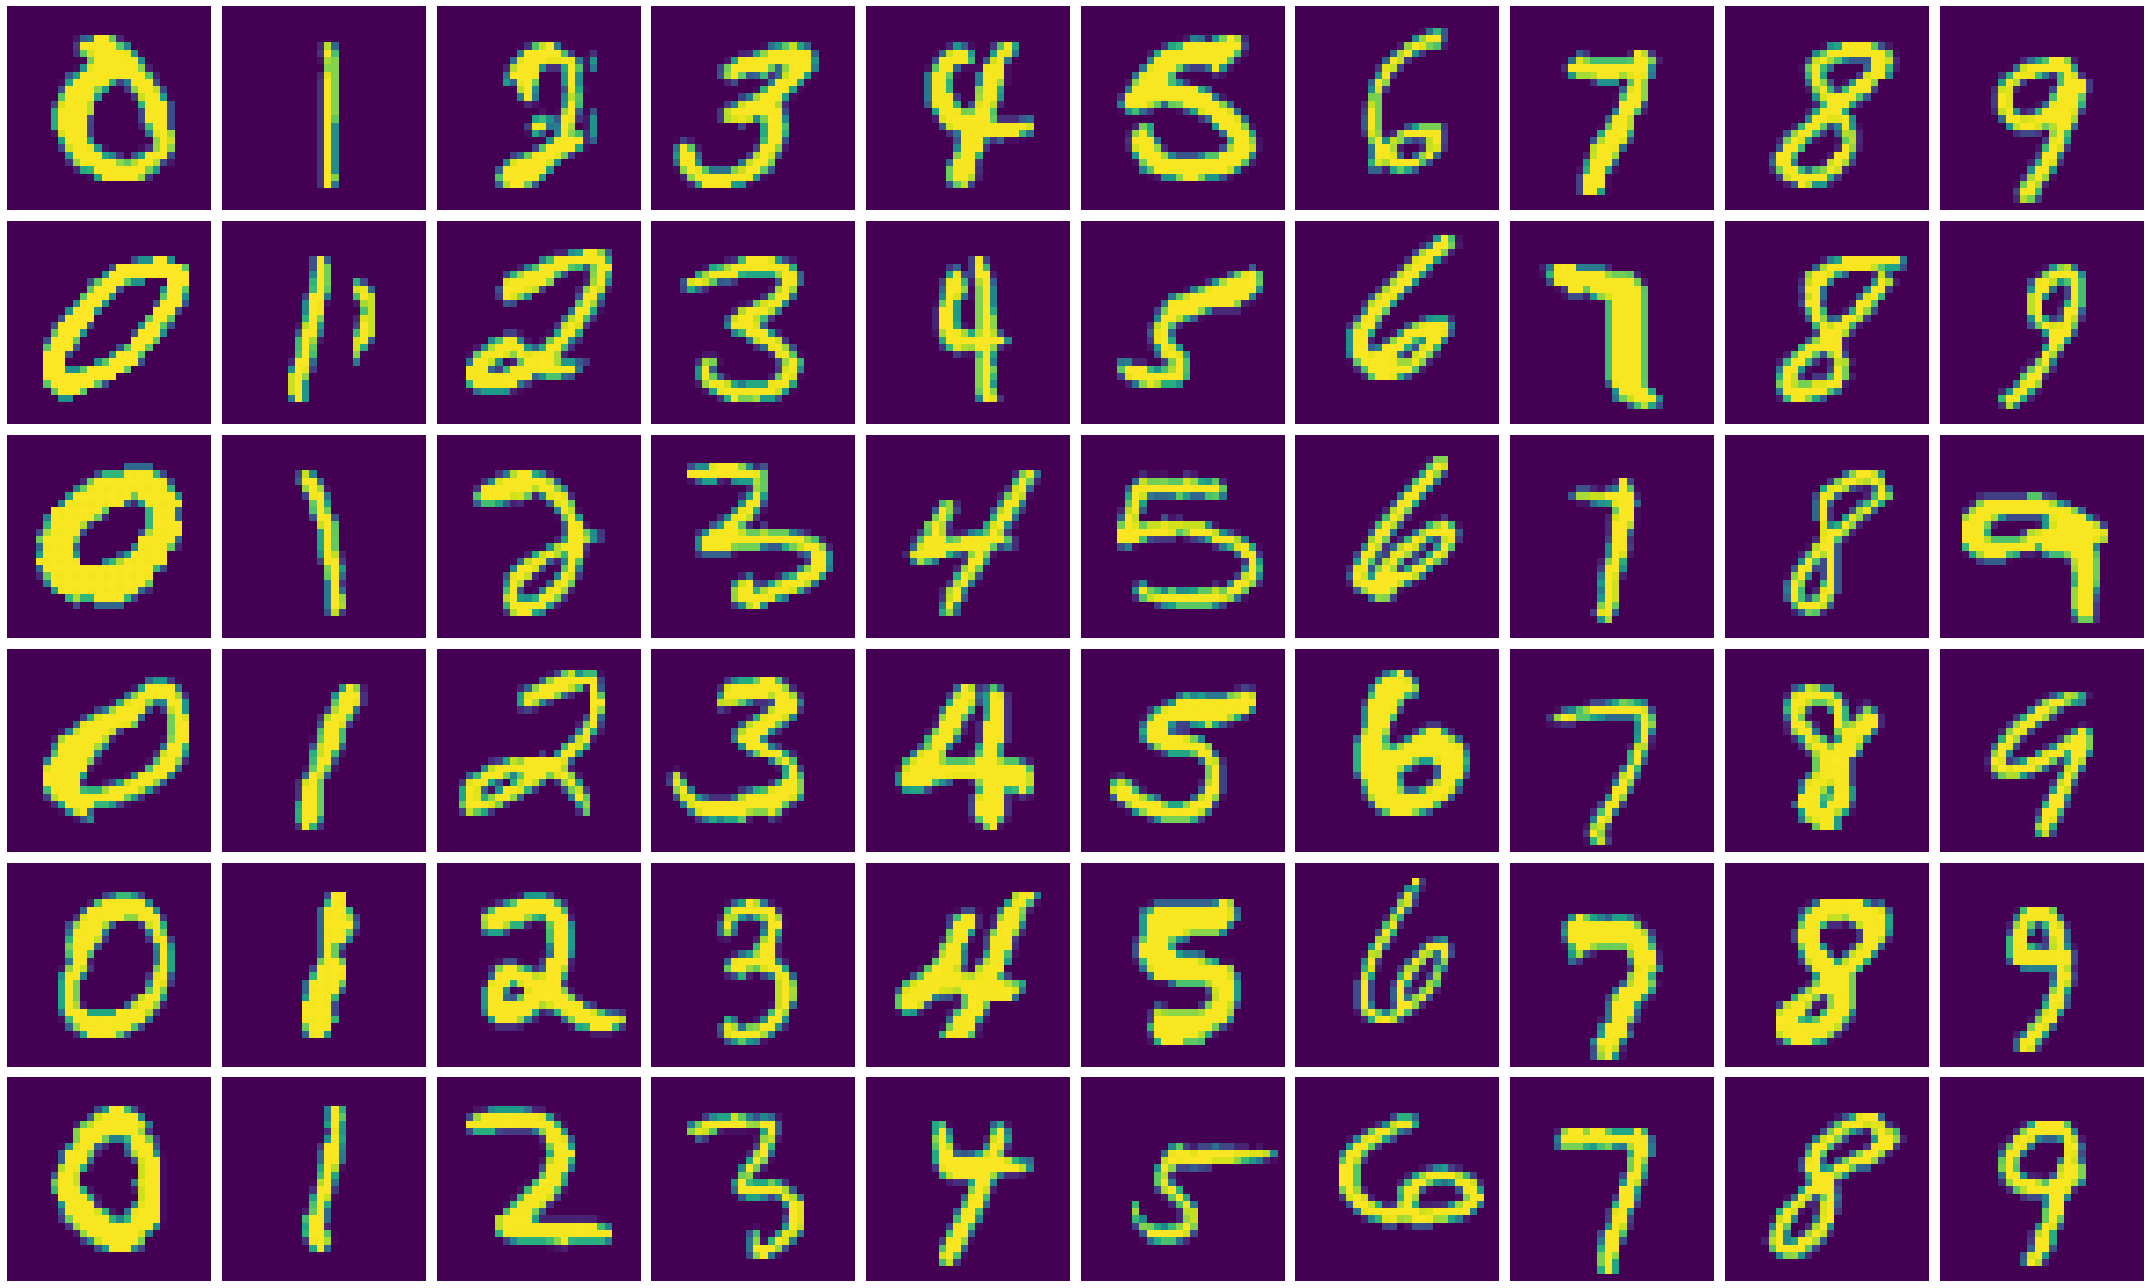

In [47]:
fig, axs = plt.subplots(6, 10, figsize=(3*10, 3*6))

for y in range(10):
    images_to_choose = images[torch.where(labels == y)] 

    for x in range(6):
        axs[x,y].imshow(images_to_choose[x, 0], vmin=-1, vmax=1)
    
        axs[x,y].axis('off')
        
plt.tight_layout()
plt.savefig('mnist_sample.png')
         
        


## MNIST-C

In [48]:
mnist_c_variants = sorted([
    'pixelate', 'dotted_line', 'gaussian_blur', 'elastic_transform', 'jpeg_compression', 'speckle_noise',
    'glass_blur', 'spatter', 'translate', 'fog', 'shear', 'scale', 'zigzag', 'defocus_blur', 'gaussian_noise',
    'contrast', 'canny_edges', 'zoom_blur', 'line', 'pessimal_noise', 'rotate', 'brightness', 'shot_noise',
    'saturate', 'motion_blur', 'snow', 'inverse', 'impulse_noise', 'stripe', 'quantize', 'frost'
])

mnist_c_variants.insert(0, 'identity')
mnist_c_variants

['identity',
 'brightness',
 'canny_edges',
 'contrast',
 'defocus_blur',
 'dotted_line',
 'elastic_transform',
 'fog',
 'frost',
 'gaussian_blur',
 'gaussian_noise',
 'glass_blur',
 'impulse_noise',
 'inverse',
 'jpeg_compression',
 'line',
 'motion_blur',
 'pessimal_noise',
 'pixelate',
 'quantize',
 'rotate',
 'saturate',
 'scale',
 'shear',
 'shot_noise',
 'snow',
 'spatter',
 'speckle_noise',
 'stripe',
 'translate',
 'zigzag',
 'zoom_blur']

In [49]:
def get_mnistc_loader(variant):
    dataset = load_mnistc(variant, transform=small_transform())
    return torch.utils.data.DataLoader(dataset, batch_size=25, shuffle=False, num_workers=1)
    
img_data = []

for variant in mnist_c_variants:
    loader = get_mnistc_loader(variant)

    imgs, lbls = next(iter(loader))
    img_data.append(imgs)

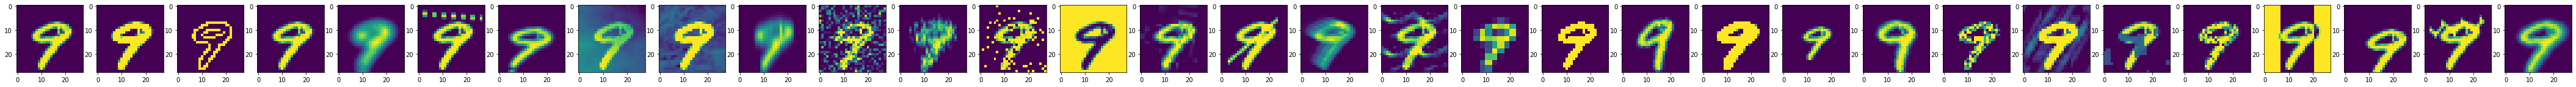

In [50]:
fig, axs = plt.subplots(1, len(img_data), figsize=(25*3,3))
for i in range(len(img_data)):
    axs[i].imshow(img_data[i][9,0])

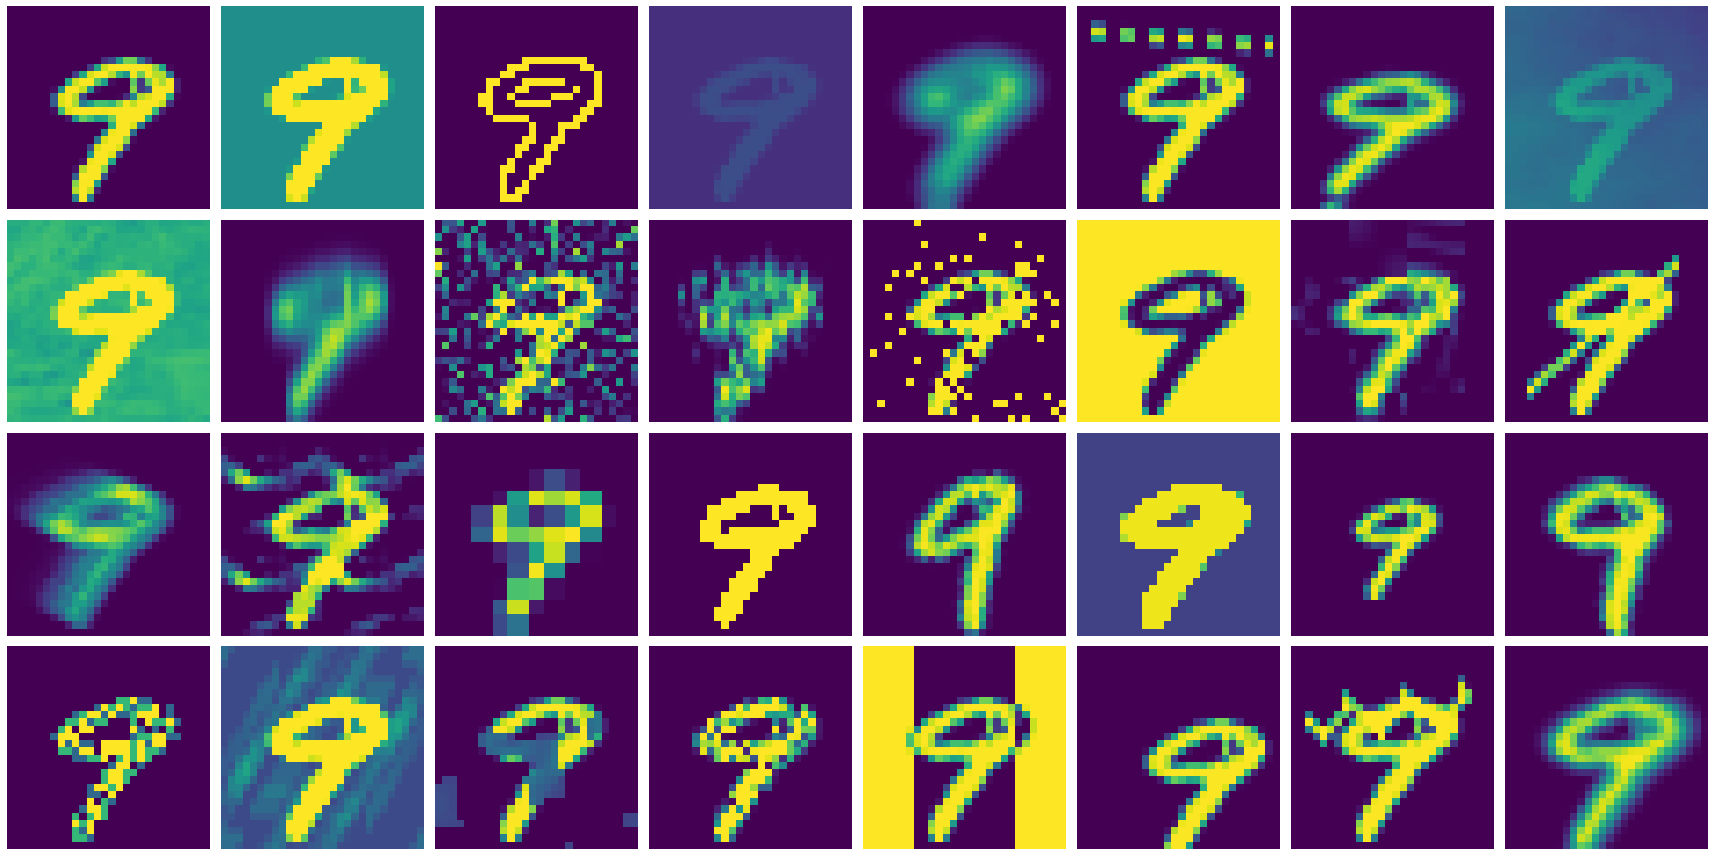

In [51]:
fig, axs = plt.subplots(4, 8, figsize=(8*3, 4*3))

for y in range(8):
    for x in range(4):
        idx = y + 8*x
        if idx >= len(img_data):
            axs[x,y].set_axis_off()
            continue
            
        axs[x,y].imshow(img_data[idx][9,0], vmin=-1, vmax=1)
        axs[x,y].axis('off')
        #axs[x,y].set_title(mnist_c_variants[idx], fontsize=28, y=1.02)
        
        
#axs[0,0].set_title('MNIST', fontsize=28, y=1.02)
plt.subplots_adjust(wspace=0.2, hspace=0.25)
plt.tight_layout()
plt.savefig('mnist_c_sample.png')
#plt.savefig('mnist_c_sample__named.png')

In [27]:
for i in range(len(img_data)):
    print(i, img_data[i].min(), img_data[i].max())

0 tensor(-1.) tensor(1.)
1 tensor(-0.0039) tensor(1.)
2 tensor(-1.) tensor(1.)
3 tensor(-0.9137) tensor(-0.4745)
4 tensor(-1.) tensor(0.8510)
5 tensor(-1.) tensor(1.)
6 tensor(-1.) tensor(1.)
7 tensor(-1.) tensor(0.7804)
8 tensor(-0.7882) tensor(1.)
9 tensor(-1.) tensor(1.)
10 tensor(-1.) tensor(1.)
11 tensor(-1.) tensor(0.9922)
12 tensor(-1.) tensor(1.)
13 tensor(-1.) tensor(1.)
14 tensor(-1.) tensor(1.)
15 tensor(-1.) tensor(1.)
16 tensor(-1.) tensor(0.9843)
17 tensor(-1.) tensor(1.)
18 tensor(-1.) tensor(1.)
19 tensor(-1.) tensor(1.)
20 tensor(-1.) tensor(1.)
21 tensor(-0.6157) tensor(0.9529)
22 tensor(-1.) tensor(1.)
23 tensor(-1.) tensor(1.)
24 tensor(-1.) tensor(1.)
25 tensor(-0.5529) tensor(1.)
26 tensor(-1.) tensor(1.)
27 tensor(-1.) tensor(1.)
28 tensor(-1.) tensor(1.)
29 tensor(-1.) tensor(1.)
30 tensor(-1.) tensor(1.)
31 tensor(-1.) tensor(1.)


In [148]:
grouped_variants = [
    #{
    #    'name': 'Original',
    #    'variants': ['identity']
    #},
    {
        'name': 'Local Noise',
        'variants': ['canny_edges', 'defocus_blur', 'gaussian_blur', 'glass_blur', 'motion_blur', 'pixelate', 'shot_noise', 'speckle_noise', 'zoom_blur']
    },
    {
        'name': 'Global Noise',
        'variants': ['fog', 'frost', 'jpeg_compression', 'gaussian_noise', 'impulse_noise', 'pessimal_noise', 'snow', 'spatter']
    },
    {
        'name': 'Transformations',
        'variants': ['elastic_transform', 'rotate', 'scale', 'shear', 'translate']
    },
    {
        'name': 'Superimposed Objects',
        'variants': ['dotted_line', 'line', 'zigzag']
    },
    {
        'name': 'Image Settings',
        'variants': ['brightness', 'contrast', 'inverse', 'quantize', 'saturate', 'stripe']
    }
]
grouped_variants

[{'name': 'Local Noise',
  'variants': ['canny_edges',
   'defocus_blur',
   'gaussian_blur',
   'glass_blur',
   'motion_blur',
   'pixelate',
   'shot_noise',
   'speckle_noise',
   'zoom_blur']},
 {'name': 'Global Noise',
  'variants': ['fog',
   'frost',
   'jpeg_compression',
   'gaussian_noise',
   'impulse_noise',
   'pessimal_noise',
   'snow',
   'spatter']},
 {'name': 'Transformations',
  'variants': ['elastic_transform', 'rotate', 'scale', 'shear', 'translate']},
 {'name': 'Superimposed Objects',
  'variants': ['dotted_line', 'line', 'zigzag']},
 {'name': 'Image Settings',
  'variants': ['brightness',
   'contrast',
   'inverse',
   'quantize',
   'saturate',
   'stripe']}]

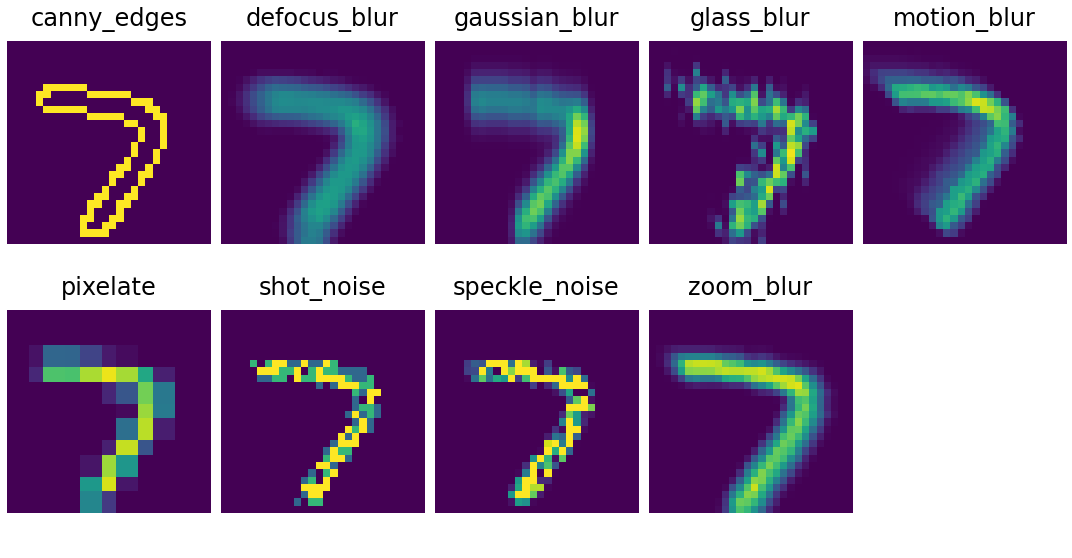

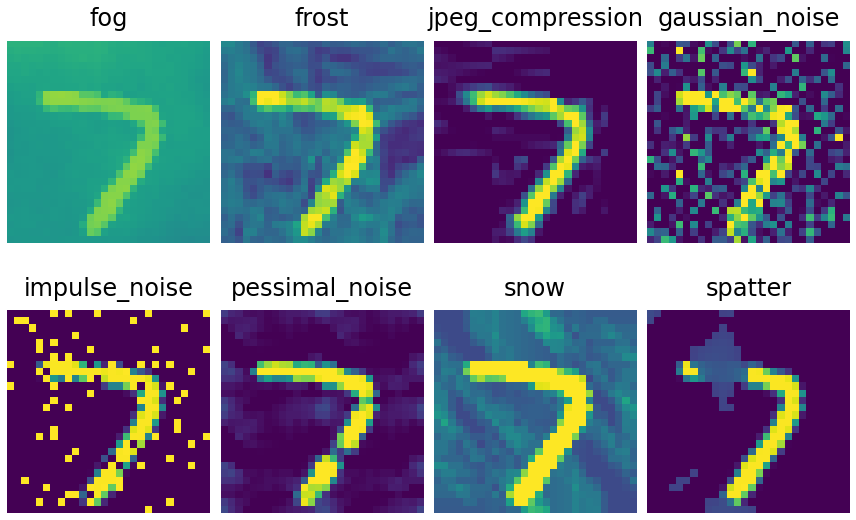

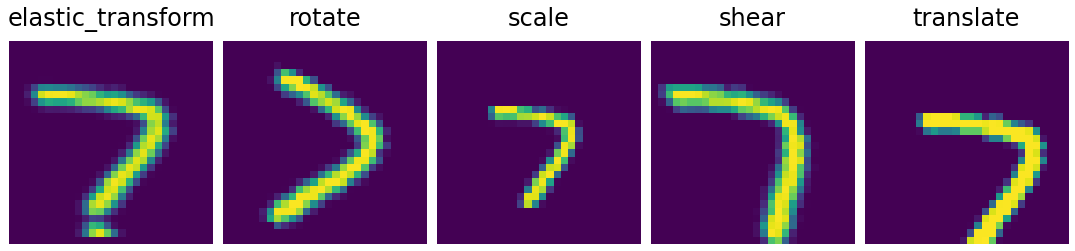

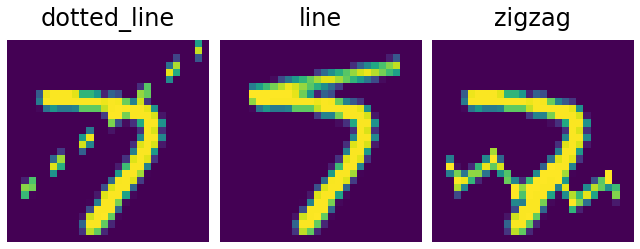

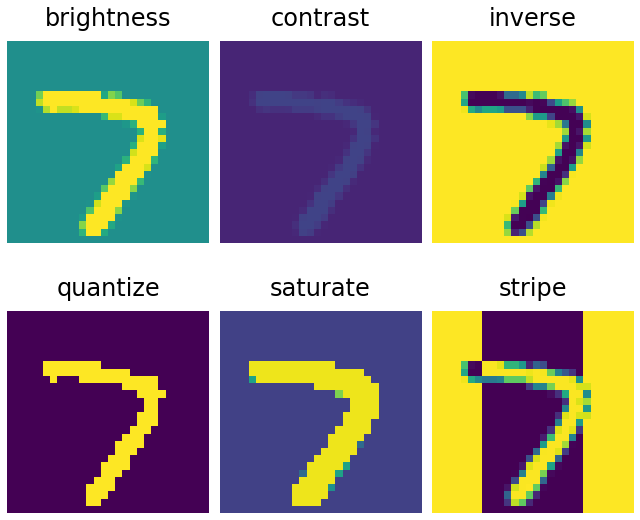

In [150]:
max_len = max([len(x['variants']) for x in grouped_variants])
img_idx = 17

#fig, axs = plt.subplots(len(grouped_variants), max_len + 1, figsize=(3*(max_len + 1), 3*len(grouped_variants)))

for v in range(len(grouped_variants)):
    
    group = grouped_variants[v]
    num_imgs = len(group['variants'])
    #print('===============')
    #print(group['name'])
    
    if num_imgs > 5:
        if num_imgs / 4 > 2:
            divisor = 5
        elif num_imgs / 3 > 2:
            divisor = 4
        else:
            divisor = 3
            
        new_num_imgs = num_imgs // divisor + 1
        fig, axs = plt.subplots(2, divisor, figsize=(3*divisor, 4*2))
        
        for x in range(divisor):
            for y in range(2):
                idx = x + divisor*y
                axs[y,x].axis('off')
                
                if idx >= num_imgs:
                    continue

                variant_name = group['variants'][idx]
                axs[y,x].imshow(img_data[mnist_c_variants.index(variant_name)][img_idx,0], vmin=-1, vmax=1)
                axs[y,x].set_title(variant_name, fontsize=24, pad=15)
                
                #print(idx, variant_name, divisor)
        
    else:
        fig, axs = plt.subplots(1, num_imgs, figsize=(3*num_imgs, 4))
        for x in range(len(group['variants'])):
            if x < len(group['variants']):
                variant_name = group['variants'][x]
                axs[x].imshow(img_data[mnist_c_variants.index(variant_name)][img_idx,0], vmin=-1, vmax=1)
                axs[x].set_title(variant_name, fontsize=24, pad=15)
            axs[x].axis('off')
        
    #plt.suptitle(group['name'], fontsize=32)
    plt.tight_layout()
    #plt.subplots_adjust(top=0.9)
    plt.savefig('mnistc_group__' + '_'.join(group['name'].lower().split(' ')) + '.png')
    plt.show()
    plt.close()